# return & FFD & ADF
- 对一阶差分的return做统计分析
- 对close price做分数阶差分
- 对差分结果做ADF，找到满足序列平稳情况下，记忆力最强的序列

### 1. 导入必要的库

In [1]:
# 1. Import dependencies and load Dollar Bars data
from pathlib import Path
from scipy import stats
import numpy as np
import pandas as pd
import numba
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from src.utils.logger import logger

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

project_root = Path.cwd().parent.parent  # two levels above notebooks/data_process/
bars_path = project_root / "data" / "preprocess_data" \
    / "dollar_bars" / "BTCUSDT" / "BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m.csv"

df = pd.read_csv(bars_path)

### 2. return 统计数据

In [ ]:
# 2. Compute log returns
col_data = df["timestamp"]

if np.issubdtype(col_data.dtype, np.number):
    ts = col_data.astype("int64")
    # Use number of digits to distinguish ms / us: <=13 digits -> ms, >13 digits -> us
    ts_len = ts.astype("string").str.len()
    ms_mask = ts_len <= 13
    us_mask = ts_len > 13
    logger.info(f"Time column timestamp: {ms_mask.sum()} rows as ms, {us_mask.sum()} rows as us")
    
    dt = pd.Series(index=ts.index, dtype="datetime64[ns]")
    if ms_mask.any():
        dt.loc[ms_mask] = pd.to_datetime(ts[ms_mask], unit="ms", errors="coerce")
    if us_mask.any():
        dt.loc[us_mask] = pd.to_datetime(ts[us_mask], unit="us", errors="coerce")
    df["dt"] = dt

df = df.set_index("dt").sort_index()

# Compute log returns: log(p_t / p_{t-1})
df["log_ret"] = np.log(df["close"]).diff()

# Drop the first NaN
returns = df["log_ret"].dropna()

logger.info("Basic statistics of log returns:")
logger.info(f"{returns.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])}")

mean = returns.mean()
std = returns.std()
skew = stats.skew(returns)
kurt = stats.kurtosis(returns, fisher=True)  # Fisher=True -> 0 means normal distribution

logger.info(f"Mean: {mean}")
logger.info(f"Standard deviation: {std}")
logger.info(f"Skewness: {skew}")
logger.info(f"Kurtosis (Fisher): {kurt}")

| INFO     | __main__:<module>:10 - Time column timestamp: 0 rows as ms, 82145 rows as us
| INFO     | __main__:<module>:27 - Basic statistics of log returns:
| INFO     | __main__:<module>:28 - count    8.214400e+04
mean    -8.106765e-07
std      1.581600e-03
min     -2.245976e-02
1%      -4.144171e-03
5%      -2.468055e-03
50%     -5.572076e-07
95%      2.502658e-03
99%      4.233636e-03
max      1.577194e-02
Name: log_ret, dtype: float64
| INFO     | __main__:<module>:35 - Mean: -8.10676493705736e-07
| INFO     | __main__:<module>:36 - Standard deviation: 0.0015815999806702166
| INFO     | __main__:<module>:37 - Skewness: 0.03209583437633453
| INFO     | __main__:<module>:38 - Kurtosis (Fisher): 4.404423651115859


### 3. return 时序图 分布直方图 Boxplot图 QQ图 

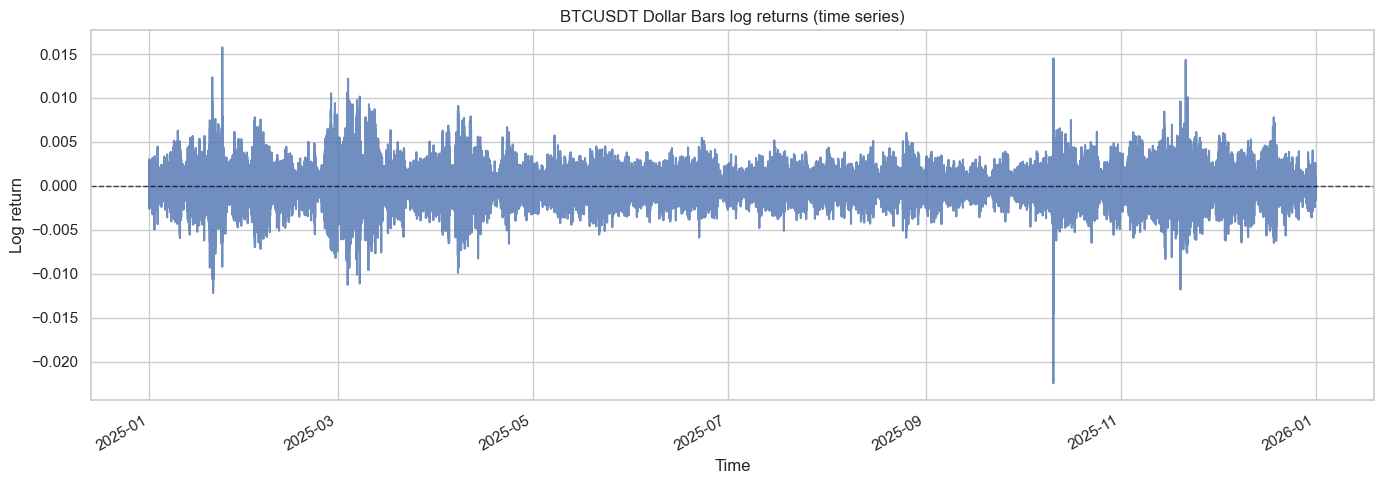

In [ ]:
# 3. Time series of log returns
plt.figure(figsize=(14, 5))
returns.plot(alpha=0.8)
plt.title("BTCUSDT Dollar Bars log returns (time series)")
plt.xlabel("Time")
plt.ylabel("Log return")
plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

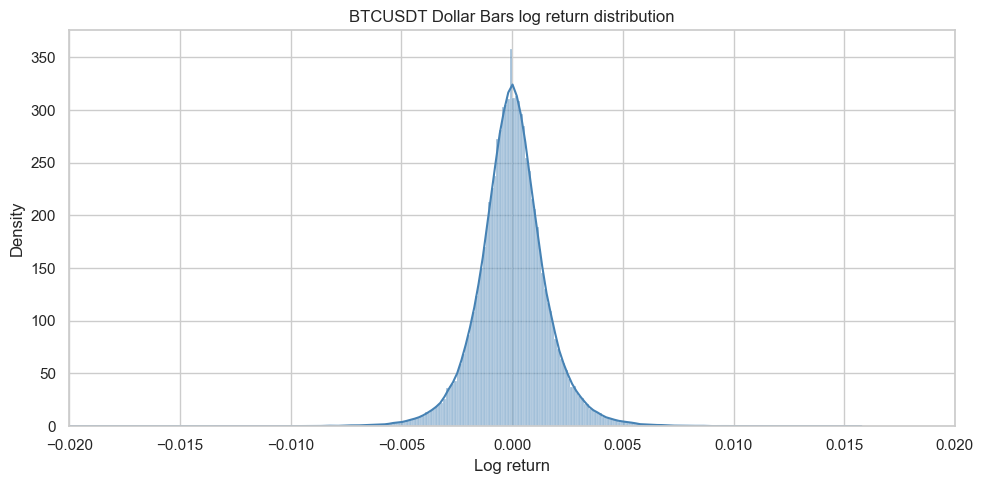

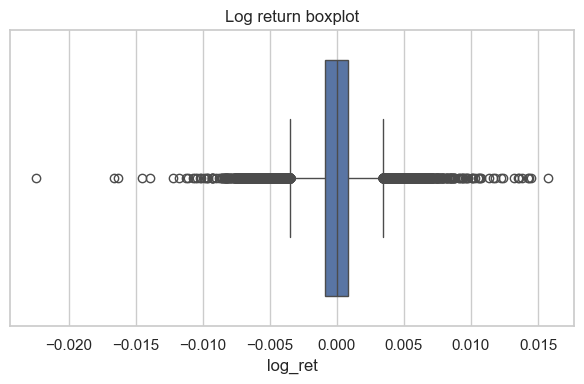

In [ ]:
# 4. Distribution of log returns: histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=320, kde=True, stat="density", color="steelblue")
plt.title("BTCUSDT Dollar Bars log return distribution")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.xlim(-0.02, 0.02)
plt.tight_layout()
plt.show()

# 5. Boxplot to inspect tails and skewness
plt.figure(figsize=(6, 4))
sns.boxplot(x=returns, orient="h")
plt.title("Log return boxplot")
plt.tight_layout()
plt.show()

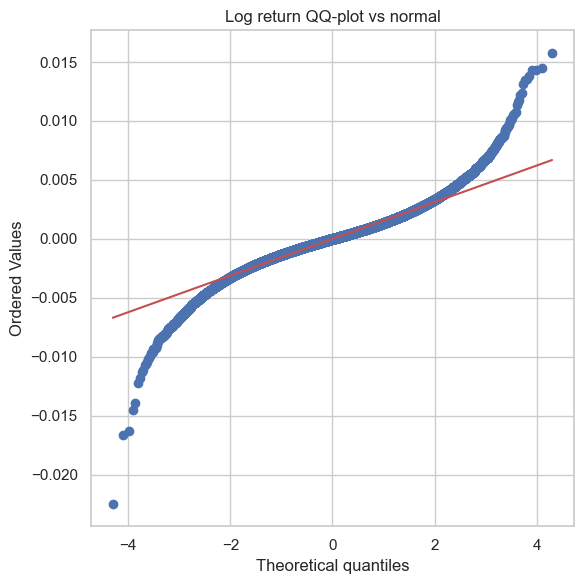

In [ ]:
# 6. QQ plot
fig = plt.figure(figsize=(6, 6))
stats.probplot(returns, dist="norm", plot=plt)
plt.title("Log return QQ-plot vs normal")
plt.tight_layout()
plt.show()

### 4. 寻找ffd计算的d值

In [3]:
# 准备数据
log_close = np.log(df["close"]).replace([np.inf, -np.inf], np.nan).dropna()

# 核心算法库 (Core Algorithms)
def get_weights_ffd(d, thresh=1e-5, max_width=20000):
    """
    计算分数阶差分的权重 (Fixed-Width Window)。
    
    改进点：
    - max_width 默认值提升至 20,000。
    - 只有当 d 极小导致窗口即使到了 2万 还没衰减到 thresh 时，才强制截断。
    - 保证了绝大多数情况下由 thresh (精度) 决定窗口宽度，而非人为限制。
    """
    weights = [1.0]
    k = 1
    while True:
        # 递推公式
        w_k = -weights[-1] * (d - k + 1) / k
        
        # 1. 精度达标，停止 (主要停止条件)
        if abs(w_k) < thresh:
            break
            
        # 2. 安全截断，防止死循环或内存爆炸 (保险丝)
        if len(weights) >= max_width:
            break
            
        weights.append(w_k)
        k += 1
        
    return np.array(weights[::-1], dtype=np.float64)

@numba.jit(nopython=True, parallel=True, cache=True)
def frac_diff_ffd_numba(values, weights):
    """
    Numba 加速的差分计算引擎。
    """
    width = len(weights)
    n = len(values)
    out = np.full(n, np.nan, dtype=np.float64)
    
    # 使用 prange 进行并行循环 (并行计算每一个时间点的差分值)
    for i in numba.prange(width - 1, n):
        window = values[i - width + 1 : i + 1]
        
        # 手动检查 NaN (Numba 中比 np.isnan(window).any() 更快且兼容性更好)
        has_nan = False
        for j in range(width):
            if np.isnan(window[j]):
                has_nan = True
                break
        
        if not has_nan:
            out[i] = np.dot(weights, window)
            
    return out

def frac_diff_ffd(series, d, thresh=1e-5):
    """FFD 主函数：整合权重计算与 Numba 加速"""
    # 这里的 max_width 设为 20000，足以应对 d=0.1 左右的情况
    weights = get_weights_ffd(d, thresh=thresh, max_width=20000)
    
    # 如果窗口比数据还长，无法计算
    if len(weights) > len(series):
        return pd.Series(np.nan, index=series.index)
        
    values = series.to_numpy(dtype=np.float64)
    out_values = frac_diff_ffd_numba(values, weights)
    return pd.Series(out_values, index=series.index)

def adf_summary(series, min_obs=100, maxlag=48):
    """
    ADF 检验辅助函数。
    - maxlag=48: 大概检测4个小时长度的相关性
    """
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(clean) < min_obs:
        return {"p_value": np.nan, "adf_stat": np.nan, "n_obs": len(clean), "corr": np.nan}
    
    # 执行 ADF 检验
    adf = adfuller(clean.to_numpy(dtype=float), regression="c", autolag="AIC", maxlag=maxlag)
    
    return {
        "p_value": adf[1], 
        "adf_stat": adf[0], 
        "n_obs": adf[3],
        "used_lag": adf[2]
    }

# 网格搜索函数
def grid_search():
    d_grid = np.round(np.arange(0.0, 1.01, 0.01), 2)
    results = []

    logger.info(f"Starting FFD+ADF scan (Parallelized): {len(d_grid)} times.")

    # 使用 tqdm 显示进度条
    for d in tqdm(d_grid, desc="ADF Scan", unit="times"):
        # 1. 计算差分
        ffd_series = frac_diff_ffd(log_close, d, thresh=1e-5)

        # 2. 计算 ADF 指标
        stats = adf_summary(ffd_series, min_obs=100, maxlag=12)

        # 3. 计算相关性 (额外增加的指标)
        # 这能让你看到 d 增加时，与原始价格的相关性是如何下降的
        if stats["n_obs"] > 100:
            # 注意：这里要对齐索引计算相关性
            corr = ffd_series.corr(log_close)
        else:
            corr = np.nan

        results.append({"d": d, "corr": corr, **stats})

        if stats["p_value"] <0.05:
            break

    # 转换结果为 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# 搜索入口函数
def search_best_d():
    results_df = grid_search()
    valid = results_df[results_df["p_value"] < 0.05]

    if not valid.empty:
        # 找到最小的 d
        best_row = valid.iloc[0]
        best_d = float(best_row["d"])

        # 理论最优是 best_d，但为了稳健，建议实盘加 0.05
        robust_d = round(best_d + 0.05, 2)

        logger.info(f"{'='*60}")
        logger.info(f"MATHEMATICAL OPTIMUM d: {best_d} (p-value: {best_row['p_value']:.4f})")
        logger.info(f"Correlation with Price: {best_row['corr']:.4f}")
        logger.info(f"Valid Observations: {int(best_row['n_obs'])}")
        logger.info(f"{'-'*60}")
        logger.info(f"RECOMMENDED d (for feature eng): {robust_d}")
        logger.info(f"(Adding small buffer to ensure stationarity in future data)")
        logger.info(f"{'='*60}")

        # ==========================================
        # 5. 生成最终特征 (Final Feature Generation)
        # ==========================================
        # 这一步生成你接下来要用的列
        logger.info(f"Generating final feature column 'ffd_log_close' with d={robust_d}...")
        df['ffd_log_close'] = frac_diff_ffd(log_close, d=robust_d, thresh=1e-5)

        # 检查一下最终数据有多少非空
        valid_count = df['ffd_log_close'].count()
        logger.info(f"Feature created. Valid rows: {valid_count}/{len(df)}")

    else:
        logger.error("No d value found that makes the series stationary! Check data quality or increase d range.")

    logger.info(f"Detailed ADF results for best FFD series (d={best_d}):")

In [ ]:
# 开始搜索
search_best_d()

| INFO     | __main__:grid_search:95 - Starting FFD+ADF scan (Parallelized): 101 times.


ADF Scan:   9%|▉         | 9/101 [00:07<01:14,  1.24times/s]

| INFO     | __main__:search_best_d:135 - ============================================================
| INFO     | __main__:search_best_d:136 - MATHEMATICAL OPTIMUM d: 0.09 (p-value: 0.0469)
| INFO     | __main__:search_best_d:137 - Correlation with Price: 0.9950
| INFO     | __main__:search_best_d:138 - Valid Observations: 78112
| INFO     | __main__:search_best_d:139 - ------------------------------------------------------------
| INFO     | __main__:search_best_d:140 - RECOMMENDED d (for feature eng): 0.14
| INFO     | __main__:search_best_d:141 - (Adding small buffer to ensure stationarity in future data)
| INFO     | __main__:search_best_d:142 - ============================================================
| INFO     | __main__:search_best_d:148 - Generating final feature column 'ffd_log_close' with d=0.14...
| INFO     | __main__:search_best_d:153 - Feature created. Valid rows: 78168/82145
| INFO     | __main__:search_best_d:158 - Detailed ADF results for best FFD series (d=0.09)

In [12]:
ffd_series = frac_diff_ffd(log_close, 0.15, thresh=1e-5)

stats = adf_summary(ffd_series, min_obs=100, maxlag=216) # 过去一天相关性

logger.info(f"p_value: {stats['p_value']}")
logger.info(f"adf_stat: {stats['adf_stat']}")
logger.info(f"n_obs: {stats['n_obs']}")
logger.info(f"used_lag: {stats['used_lag']}")

| INFO     | __main__:<module>:5 - p_value: 0.04204214678884719
| INFO     | __main__:<module>:6 - adf_stat: -2.9293294302276203
| INFO     | __main__:<module>:7 - n_obs: 78108
| INFO     | __main__:<module>:8 - used_lag: 136


### 5. 根据之前得到的d值计算ffd，并存储

In [20]:
# ==========================================
# 根据d=0.15计算分数阶差分并保存
# ==========================================

# 参数设置
d_value = 0.15

# 计算分数阶差分
logger.info(f"Computing fractional-order differencing with d={d_value}...")
df['ffd_close'] = frac_diff_ffd(log_close, d=d_value, thresh=1e-5)

# 检查结果
valid_count = df['ffd_close'].count()
logger.info(f"FFD computed. Valid rows: {valid_count}/{len(df)}")

# 保存到新文件（只保留原始列 + ffd_close）
output_path = project_root / "data" / "preprocess_data" / "factor" / "BTCUSDT" / \
    "BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m_with_ffd.csv"
Path.mkdir(output_path.parent, parents=True, exist_ok=True)

original_cols = ["timestamp", "open", "high", "low", "close", "volume", "dollar_volume", "num_trades", "close_time"]
save_cols = original_cols + ["ffd_close"]
df[save_cols].to_csv(output_path, index=False)
logger.info(f"Data saved to: {output_path}")

| INFO     | __main__:<module>:9 - Computing fractional-order differencing with d=0.15...
| INFO     | __main__:<module>:14 - FFD computed. Valid rows: 78245/82145
| INFO     | __main__:<module>:24 - Data saved to: e:\B\Economic&Finance\code\CryptoQuant\data\preprocess_data\factor\BTCUSDT\BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m_with_ffd.csv


### 6. ffd_close统计分析

| INFO     | __main__:<module>:2 - 
原始close价格统计:
| INFO     | __main__:<module>:3 -   min: 74582.01
| INFO     | __main__:<module>:4 -   max: 126164.42
| INFO     | __main__:<module>:5 -   mean: 101628.30
| INFO     | __main__:<module>:8 - 
ffd_close统计（d=0.15）:
| INFO     | __main__:<module>:9 -   min: 2.8951
| INFO     | __main__:<module>:10 -   max: 3.0674
| INFO     | __main__:<module>:11 -   mean: 2.9966
| INFO     | __main__:<module>:12 -   std: 0.0334
| INFO     | __main__:<module>:16 - 
权重信息 (d=0.15):
| INFO     | __main__:<module>:17 -   权重窗口宽度: 3901
| INFO     | __main__:<module>:18 -   权重之和: 0.260040
| INFO     | __main__:<module>:19 -   首个权重 (w[0]): -0.000010
| INFO     | __main__:<module>:20 -   第一个权重 (w[-1]): 1.000000
| INFO     | __main__:<module>:21 -   正权重之和: 1.000000
| INFO     | __main__:<module>:22 -   负权重之和: -0.739960
| INFO     | __main__:<module>:25 - 
数学含义解释:
| INFO     | __main__:<module>:26 - FFD是Fixed-Width Window分数阶差分，计算公式：
| INFO     | __main__:<module>:27 -

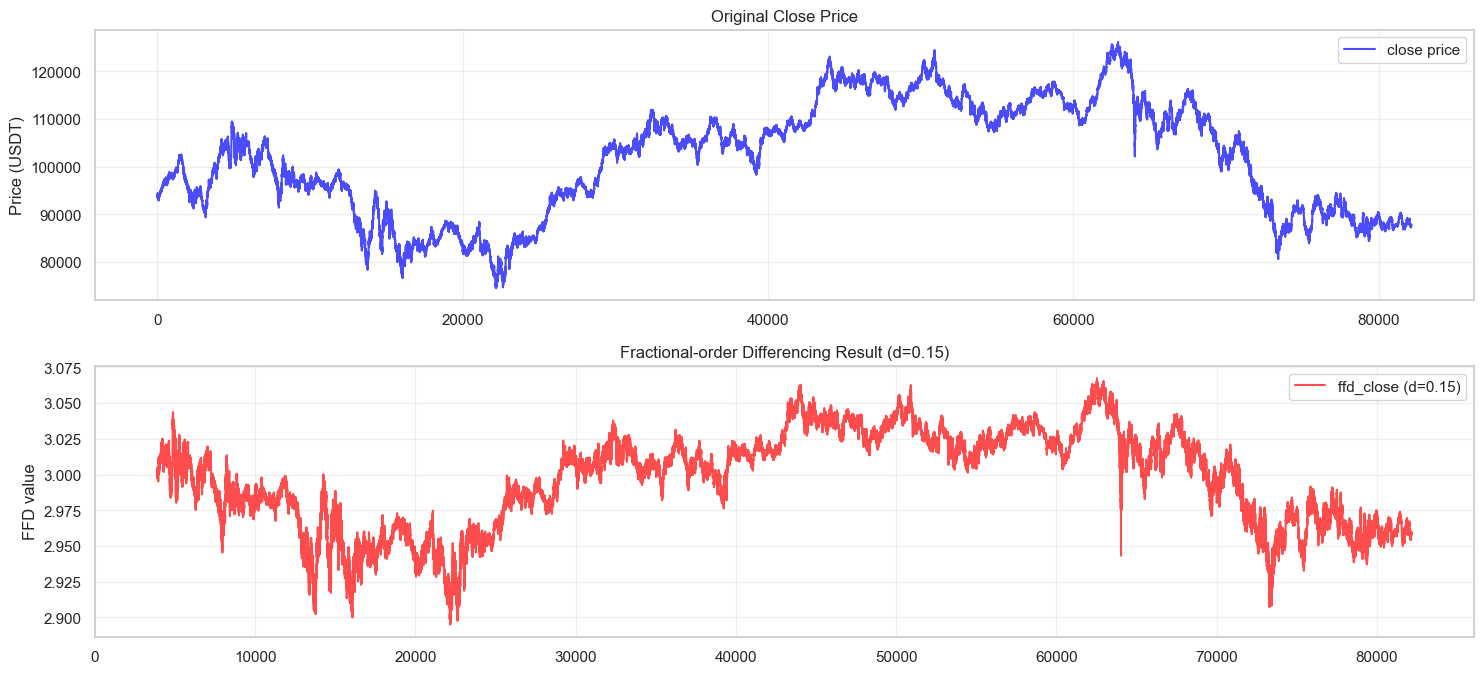

In [11]:
# 1. 检查各序列的基本统计
logger.info(f"\n原始close价格统计:")
logger.info(f"  min: {df['close'].min():.2f}")
logger.info(f"  max: {df['close'].max():.2f}")
logger.info(f"  mean: {df['close'].mean():.2f}")

valid_ffd = df['ffd_close'].dropna()
logger.info(f"\nffd_close统计（d=0.15）:")
logger.info(f"  min: {valid_ffd.min():.4f}")
logger.info(f"  max: {valid_ffd.max():.4f}")
logger.info(f"  mean: {valid_ffd.mean():.4f}")
logger.info(f"  std: {valid_ffd.std():.4f}")

# 2. 检查权重
weights = get_weights_ffd(0.15, thresh=1e-5, max_width=20000)
logger.info(f"\n权重信息 (d=0.15):")
logger.info(f"  权重窗口宽度: {len(weights)}")
logger.info(f"  权重之和: {weights.sum():.6f}")
logger.info(f"  首个权重 (w[0]): {weights[0]:.6f}")
logger.info(f"  第一个权重 (w[-1]): {weights[-1]:.6f}")
logger.info(f"  正权重之和: {weights[weights > 0].sum():.6f}")
logger.info(f"  负权重之和: {weights[weights < 0].sum():.6f}")

# 3. 数学解释
logger.info(f"\n数学含义解释:")
logger.info(f"FFD是Fixed-Width Window分数阶差分，计算公式：")
logger.info(f"  ffd_t = Σ(w_k * log_close[t-k+1])")
logger.info(f"其中 w_k 满足递推关系：w_k = -w_(k-1) * (d-k+1) / k")
logger.info(f"")
logger.info(f"FFD的数学含义：")
logger.info(f"  • d=0: 无差分，保留全部记忆性")
logger.info(f"  • 0<d<1: 部分差分，保留部分记忆性（平衡平稳性与记忆性）")
logger.info(f"  • d=1: 一阶差分（log return），记忆性完全丧失")
logger.info(f"")
logger.info(f"FFD与d=0.15的特点：")
logger.info(f"  • 保留约85%的原始序列记忆性")
logger.info(f"  • 足以使序列趋向平稳（通过ADF检验）")
logger.info(f"  • 权重窗宽={len(weights)}，表示需要这么多历史数据点")

# 4. 可视化对比
plt.figure(figsize=(15, 10))

# 原始close
plt.subplot(3, 1, 1)
df['close'].plot(label='close price', color='blue', alpha=0.7)
plt.title('Original Close Price')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid(True, alpha=0.3)

# ffd_close
plt.subplot(3, 1, 2)
df['ffd_close'].plot(label='ffd_close (d=0.15)', color='red', alpha=0.7)
plt.title('Fractional-order Differencing Result (d=0.15)')
plt.ylabel('FFD value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()